In [ ]:
%pip install tensorflow
%pip install keras-tuner --upgrade
%pip install opencv-python


import numpy as np
import matplotlib.pyplot as plt
from sklearn import set_config

# We'll build the CNN as a sequence of layers.
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, LeakyReLU, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import layers, Model
# Libraries to handle the data
import json
import os
from tqdm import tqdm
from PIL import Image
import cv2
from keras.applications import MobileNetV2

from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras import backend as K
import keras_tuner as kt
import random
from sklearn.base import BaseEstimator, TransformerMixin


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [ ]:
!unzip "archive (8).zip"



Streaming output truncated to the last 5000 lines.
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.38315357_37.6157415688.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.383170478_37.6145066674.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.383729791_37.6187867125.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.384510263_37.6198917809.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.385179849_37.6188192613.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.3876445_37.6207868997.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.388117_37.6182480314.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.389382406_37.6201492015.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.389931176_37.6215474909.png  
  inflating: planesnet/planesnet/1__20170222_231256_0c27__-122.390283641_37.6180147081.png  
  inflating: planesnet/pl

In [ ]:
%lsn

UsageError: Line magic function `%lsn` not found.


In [ ]:
with open('/content/planesnet.json', 'r') as file:
    planesnet = json.load(file)

data = np.array(planesnet['data'])
labels = np.array(planesnet['labels'])

In [ ]:
labels.shape

(32000,)

In [ ]:
def create_data(path_name):
    images = []
    labels = []
    for img in tqdm(os.listdir(path_name)):
        if(img[0]=='1'):
            labels.append(1)
        else:
            labels.append(0)
        image = Image.open(os.path.join(path_name,img))
        image = np.array(image)
        images.append(image)

    return np.array(images),np.array(labels)

images, labels = create_data('/content/planesnet/planesnet')

100%|██████████| 32000/32000 [00:03<00:00, 8109.63it/s]


In [ ]:
images.shape

(32000, 20, 20, 3)

In [ ]:
print(images[0].shape)
print(labels[50:60])

(20, 20, 3)
[0 1 0 0 1 0 0 0 0 1]


In [ ]:
for img in tqdm(os.listdir('/content/planesnet/planesnet')[0:10]):
    print(img)

100%|██████████| 10/10 [00:00<00:00, 3420.85it/s]

0__20170508_175352_0e19__-118.414613303_33.9558850567.png
0__20151118_160422_0c68__-118.07865966958363_33.84560133548656.png
0__20161212_180859_0e30__-122.388819174_37.6130939776.png
1__20170617_181435_0e0f__-122.37829480049021_37.62765173584738.png
0__20160811_174014_0e0e__-117.16599065056938_32.708227953825244.png
1__20160916_174733_0e20__-118.422929997_33.9456116016.png
0__20170714_180824_1007__-121.9508974427669_37.388773448140604.png
0__20160816_174600_0e0e__-118.399169536_33.9406138083.png
0__20161229_175033_0e0d__-118.407555009_33.9412757214.png
0__20160713_153443_0c72__-117.182487842_32.792801342.png


In [ ]:
upscale_size = (32,32)

upscaled_images = []

for img in images:
    resized_img = cv2.resize(img, upscale_size, interpolation=cv2.INTER_LINEAR)  # Using linear interpolation
    # Store the resized image in the list
    upscaled_images.append(resized_img)


In [ ]:
upscaled_images = np.array(upscaled_images)

In [ ]:
upscaled_images.shape

(32000, 32, 32, 3)

In [ ]:
upscaled_images = upscaled_images / 255

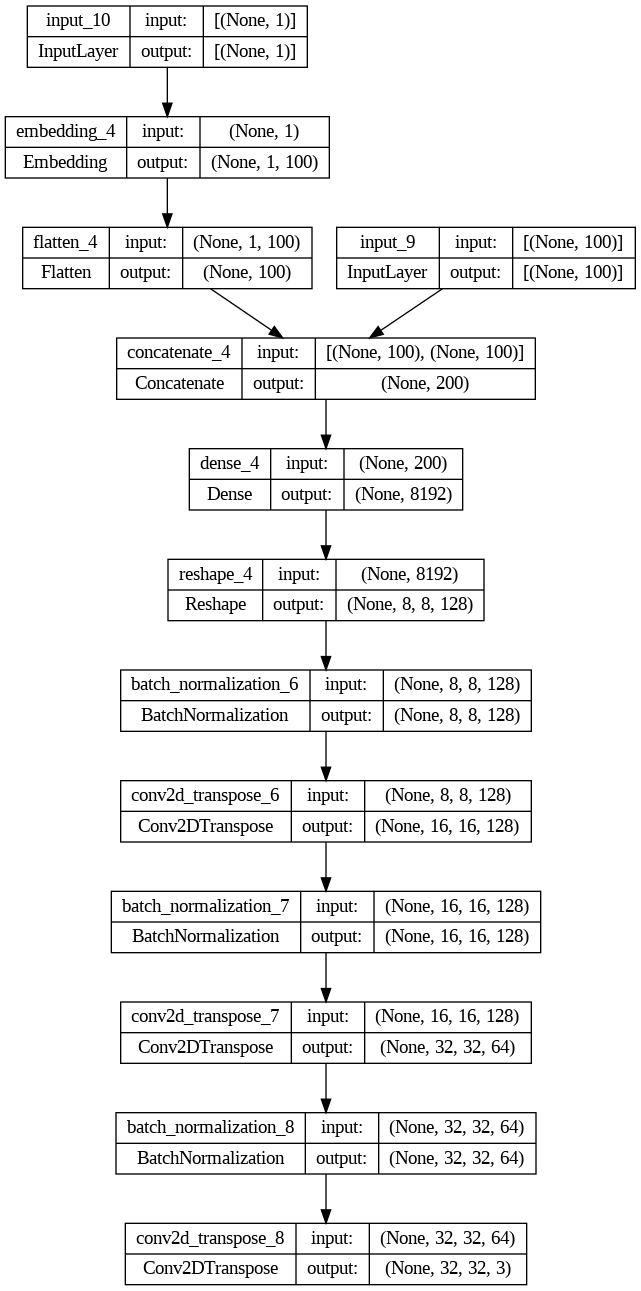

In [ ]:
from tensorflow.keras.utils import plot_model

def build_generator(latent_dim, num_classes):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, latent_dim)(label)
    label_embedding = layers.Flatten()(label_embedding)

    # Adjusted Dense layer size and reshaping to fit the smaller output size
    merged = layers.Concatenate()([noise, label_embedding])
    x = layers.Dense(128 * 8 * 8, activation=tf.keras.layers.LeakyReLU(alpha=0.2))(merged)
    x = layers.Reshape((8, 8, 128))(x)
    x = layers.BatchNormalization()(x)

    # Adjust Conv2DTranspose layers to build up to the desired final image size
    x = layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)  # 16x16
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(64, (4, 4), strides=(2, 2), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)  # 32x32
    x = layers.BatchNormalization()(x)
    x = layers.Conv2DTranspose(3, (4, 4), strides=(1, 1), padding="same", activation="tanh")(x)  # 32x32, final image size

    return Model(inputs=[noise, label], outputs=x)

def build_discriminator(image_shape, num_classes):
    image = layers.Input(shape=image_shape)
    label = layers.Input(shape=(1,))
    label_embedding = layers.Embedding(num_classes, np.prod(image_shape))(label)
    label_embedding = layers.Reshape(image_shape)(label_embedding)

    merged = layers.Concatenate()([image, label_embedding])
    x = layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(merged)  # 16x16
    x = layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2))(x)  # 8x8
    x = layers.Flatten()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return Model(inputs=[image, label], outputs=x)


def discriminator_loss(real_output, fake_output):
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output)
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss + fake_loss) * 0.5
    return total_loss

def generator_loss(true_labels, fake_output):
    return tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)

# Set model parameters
latent_dim = 100
num_classes = 2  # You have two classes, 0 and 1
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator((32, 32, 3), num_classes)

plot_model(generator, to_file='generator_model.png', show_shapes=True, show_layer_names=True)

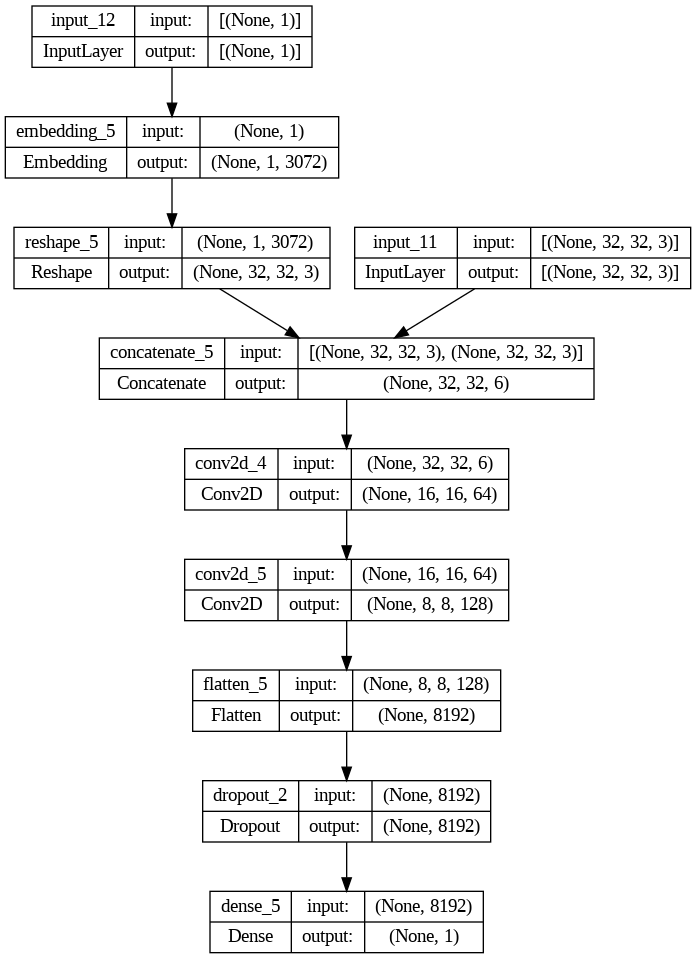

In [ ]:
plot_model(discriminator, to_file='discriminator_model.png', show_shapes=True, show_layer_names=True)

In [ ]:


# Compiling the discriminator
discriminator.compile(optimizer=Adam(1e-4), loss=discriminator_loss)

discriminator.trainable = False
gan_input = [generator.input[0], generator.input[1]]  # noise and label input
gan_output = discriminator([generator.output, generator.input[1]])  # output of generator and input label
gan = tf.keras.models.Model(gan_input, gan_output)

gan.compile(optimizer=Adam(1e-2), loss=generator_loss)

batch_size = 128

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch, label_batch in dataset:
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generated_images = generator.predict([noise, label_batch])

            # Train the discriminator (real classified as 1 and fakes as 0)
            discriminator.trainable = True  # Ensure discriminator is trainable for this phase
            d_loss_real = discriminator.train_on_batch([image_batch, label_batch], tf.ones((batch_size, 1)))
            d_loss_fake = discriminator.train_on_batch([generated_images, label_batch], tf.zeros((batch_size,1)))
            d_loss = 0.5 *  np.add(d_loss_real, d_loss_fake)

            # Train the generator (trick discriminator to classify fakes as real)
            discriminator.trainable = False  # This line is redundant after the first iteration unless you recompile the GAN model
            g_loss = gan.train_on_batch([noise, label_batch], tf.ones((batch_size, 1)))

            print(f"Epoch: {epoch} [D loss: {d_loss}] [G loss: {g_loss}]")

# Call the train function
dataset = tf.data.Dataset.from_tensor_slices((upscaled_images, labels))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
train(dataset, epochs=7)


# Assuming latent_dim is the dimensionality of your noise vector
# Number of samples to generate


4/4 [==============================] - 2s 4ms/step
Epoch: 0 [D loss: 4.2137241661548615] [G loss: 0.6843302249908447]
4/4 [==============================] - 0s 2ms/step
Epoch: 0 [D loss: 4.199798882007599] [G loss: 0.3921054005622864]
4/4 [==============================] - 0s 2ms/step
Epoch: 0 [D loss: 4.208231568336487] [G loss: 0.16477534174919128]
4/4 [==============================] - 0s 2ms/step
Epoch: 0 [D loss: 4.235503196716309] [G loss: 0.08273971825838089]
4/4 [==============================] - 0s 2ms/step
Epoch: 0 [D loss: 4.2925925105810165] [G loss: 0.04797504469752312]
4/4 [==============================] - 0s 2ms/step
Epoch: 0 [D loss: 4.37690382450819] [G loss: 0.032128047198057175]
4/4 [==============================] - 0s 2ms/step
Epoch: 0 [D loss: 4.449272260069847] [G loss: 0.02766728773713112]
4/4 [==============================] - 0s 2ms/step
Epoch: 0 [D loss: 4.521854996681213] [G loss: 0.02584642544388771]
4/4 [==============================] - 0s 2ms/step
Epoch

In [ ]:
### Now I am working on Image Data Augmentation
%pip install opencv-python
import random
import cv2

def batch_random_rotation(images, labels, angle_range=(-10, 10)):
    rotated_images = []
    rotated_labels = []
    for image, label in zip(images, labels):
        angle = random.randint(angle_range[0], angle_range[1])
        rows, cols, _ = image.shape
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        rotated_image = cv2.warpAffine(image, M, (cols, rows))
        rotated_images.append(rotated_image)
        rotated_labels.append(label)

    # Concatenate original and augmented data
    return np.concatenate((images, np.array(rotated_images))), np.concatenate((labels, np.array(rotated_labels)))


def batch_random_shift(images, labels, shift_range=(-0.1, 0.1)):
    shifted_images = []
    shifted_labels = []
    for image, label in zip(images, labels):
        h, w, _ = image.shape
        tx = random.uniform(shift_range[0] * w, shift_range[1] * w)
        ty = random.uniform(shift_range[0] * h, shift_range[1] * h)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        shifted_image = cv2.warpAffine(image, M, (w, h))
        shifted_images.append(shifted_image)
        shifted_labels.append(label)

    # Concatenate original and augmented data
    return np.concatenate((images, np.array(shifted_images))), np.concatenate((labels, np.array(shifted_labels)))

def batch_random_flip(images, labels, p=0.5):
    flipped_images = []
    flipped_labels = []
    for image, label in zip(images, labels):
        flipped_images.append(image)  # Add original first
        flipped_labels.append(label)
        if random.random() < p:
            flipped_image = cv2.flip(image, 1)  # Horizontal flip
            flipped_images.append(flipped_image)
            flipped_labels.append(label)

    # Concatenate original and augmented data
    return np.array(flipped_images), np.array(flipped_labels)



# Example usage:
# Assuming img is your original image



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(upscaled_images, labels, test_size=0.3, random_state=42, stratify=labels)

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([16800,  5600]))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify = y_train)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


(17920, 32, 32, 3)
(4480, 32, 32, 3)
(9600, 32, 32, 3)


In [ ]:
X_train, y_train = batch_random_rotation(X_train, y_train)

# Apply shift augmentation
X_train, y_train = batch_random_shift(X_train, y_train)

# Apply flip augmentation
X_train, y_train = batch_random_flip(X_train, y_train)

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1]), array([80706, 26943]))

In [ ]:
X_train.shape

(107649, 32, 32, 3)

In [ ]:
np.unique(y_train, return_counts = True)

(array([0, 1]), array([80706, 26943]))

In [ ]:
classes, counts = np.unique(y_train, return_counts=True)

In [ ]:

minority_class = 1
majority_class = 0

# Identifying counts
minority_count = counts[np.where(classes == minority_class)[0][0]]
majority_count = counts[np.where(classes == majority_class)[0][0]]

In [ ]:
num_samples = majority_count - minority_count  # Adjust this to the number of additional samples you need

# Generate random noise vectors
noise = np.random.normal(0, 1, (num_samples, latent_dim))

new_labels = np.ones((num_samples, 1))

new_labels  = new_labels.flatten()


In [ ]:
generated_images = generator.predict([noise, new_labels])

1677/1677 [==============================] - 3s 2ms/step


In [ ]:
generated_images.min()

-0.9645312

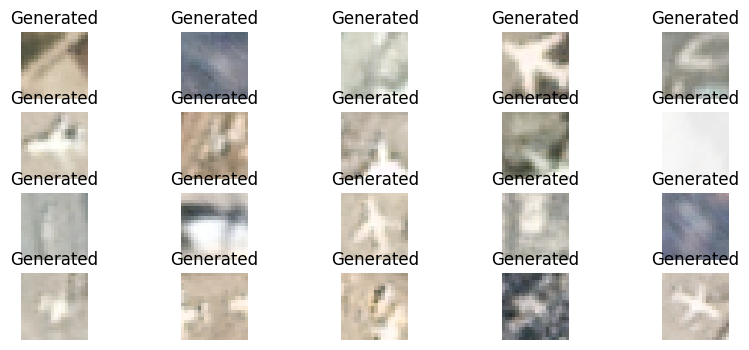

In [ ]:

import matplotlib.pyplot as plt
num_samples = 20
# Set up the figure
plt.figure(figsize=(10, 4))
for i in range(num_samples):
    # Display each image in a subplot
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(images[i])
    plt.title("Generated")
    plt.axis('off')
plt.show()

In [ ]:
generated_images = 0.5 * generated_images + 0.5
generated_images = np.clip(generated_images * 255, 0, 255).astype('uint8')

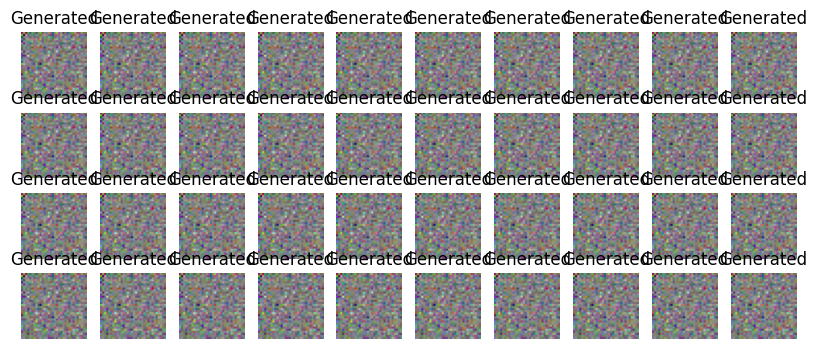

In [ ]:
import matplotlib.pyplot as plt
num_samples = 40
# Set up the figure
plt.figure(figsize=(10, 4))
for i in range(num_samples):
    # Display each image in a subplot
    ax = plt.subplot(4, 10, i + 1)
    plt.imshow(generated_images[i+1000])
    plt.title("Generated")
    plt.axis('off')
plt.show()




In [ ]:
X_train = np.concatenate((X_train, generated_images), axis=0)

# Concatenate the original labels with the new labels
y_train = np.concatenate((y_train, new_labels), axis=0)

In [ ]:
X_train.shape

(107649, 32, 32, 3)

In [ ]:
import tensorflow as tf

def f1_score(y_true, y_pred):
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    TP = tf.reduce_sum(y_true * y_pred)
    PP = tf.reduce_sum(y_pred)
    AP = tf.reduce_sum(y_true)

    precision = TP / (PP + tf.keras.backend.epsilon())
    recall = TP / (AP + tf.keras.backend.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1


In [ ]:
def build_model(hp):
    model = Sequential([
        Conv2D(
            filters=hp.Int('filters_1', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_1', values=[3, 5]),
            strides=hp.Choice('strides_1', values=[1, 2]),
            padding='same',
            activation=None,
            input_shape=(32, 32, 3)  # Adjusted input shape
        ),
        LeakyReLU(alpha=hp.Float('alpha_1', min_value=0.01, max_value=0.3, step=0.05)),
        MaxPooling2D((2, 2)),  # Consider removing or adjusting this layer based on the depth of the network
        Conv2D(
            filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
            kernel_size=hp.Choice('kernel_size_2', values=[3, 5]),
            strides=hp.Choice('strides_2', values=[1, 2]),
            padding='same',
            activation=None
        ),
        LeakyReLU(alpha=hp.Float('alpha_2', min_value=0.01, max_value=0.3, step=0.05)),
        MaxPooling2D((2, 2)),  # Evaluate if necessary; removing may depend on previous layer configurations
        Flatten(),
        Dense(
            units=hp.Int('units', min_value=64, max_value=256, step=32),
            activation='relu'
        ),
        Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.05)),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'))
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[f1_score]
    )

    return model

In [ ]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='intro_to_kt1'
)

tuner.search(X_train, y_train, epochs=7, validation_data=(X_val, y_val))


Trial 20 Complete [00h 01m 40s]
val_loss: 0.09619251638650894

Best val_loss So Far: 0.04451901838183403
Total elapsed time: 00h 33m 44s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
classification_model = build_model(best_hps)

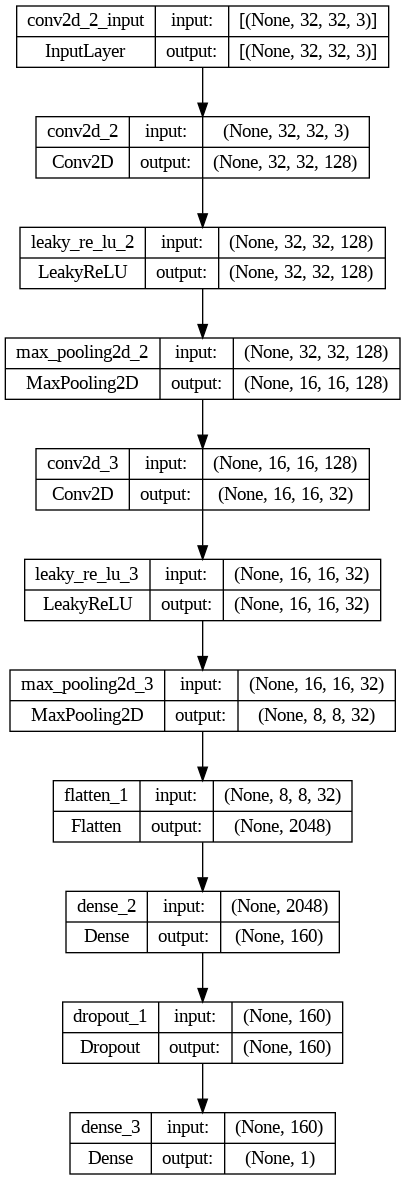

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(classification_model, to_file='classification_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
history = classification_model.fit(X_train, y_train, epochs=7, validation_data=(X_val, y_val))

Epoch 1/7
3365/3365 [==============================] - 16s 4ms/step - loss: 0.2527 - f1_score: 0.7298 - val_loss: 0.1503 - val_f1_score: 0.8682
Epoch 2/7
3365/3365 [==============================] - 14s 4ms/step - loss: 0.1379 - f1_score: 0.8863 - val_loss: 0.0941 - val_f1_score: 0.9235
Epoch 3/7
3365/3365 [==============================] - 14s 4ms/step - loss: 0.1077 - f1_score: 0.9131 - val_loss: 0.0600 - val_f1_score: 0.9529
Epoch 4/7
3365/3365 [==============================] - 14s 4ms/step - loss: 0.0903 - f1_score: 0.9275 - val_loss: 0.0702 - val_f1_score: 0.9459
Epoch 5/7
3365/3365 [==============================] - 14s 4ms/step - loss: 0.0771 - f1_score: 0.9384 - val_loss: 0.0462 - val_f1_score: 0.9639
Epoch 6/7
3365/3365 [==============================] - 13s 4ms/step - loss: 0.0667 - f1_score: 0.9465 - val_loss: 0.0436 - val_f1_score: 0.9635
Epoch 7/7
3365/3365 [==============================] - 14s 4ms/step - loss: 0.0583 - f1_score: 0.9529 - val_loss: 0.0421 - val_f1_score:

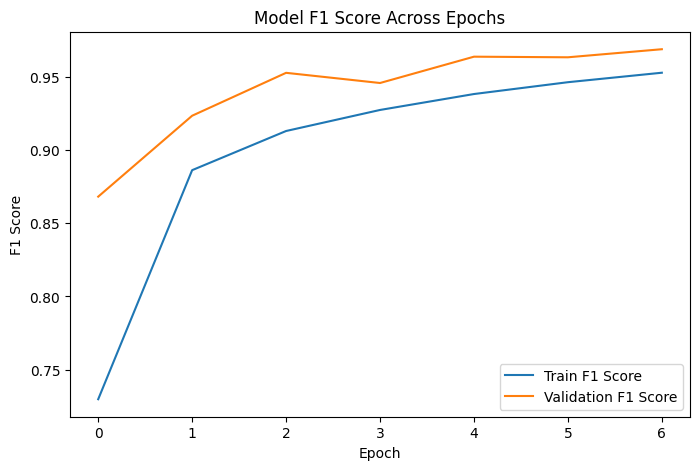

In [ ]:
train_f1_scores = history.history['f1_score']
val_f1_scores = history.history['val_f1_score']

plt.figure(figsize=(8, 5))
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.title('Model F1 Score Across Epochs')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:

def build_mobilenet_model(hp):
    # Update input_shape to 32x32x3
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    base_model.trainable = False

    inputs = base_model.input
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Tuning the number of units in the Dense layer
    x = Dense(
        units=hp.Int('units', min_value=64, max_value=512, step=128),
        activation='relu'
    )(x)

    # Adding a Dropout layer
    x = Dropout(rate=hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.05))(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    # Tuning the learning rate
    lr = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=f1_score  # Make sure the f1_score metric is correctly implemented as a Keras metric
    )

    return model

mobilenet_tuner = kt.Hyperband(
    build_mobilenet_model,
    objective='val_loss',
    max_epochs=7,
    factor=3,
    directory='my_dir',
    project_name='tune_mobilenet2'
)

mobilenet_tuner.search(X_train, y_train, epochs=7, validation_data=(X_val, y_val))

Trial 10 Complete [00h 02m 49s]
val_loss: 0.41176992654800415

Best val_loss So Far: 0.39932429790496826
Total elapsed time: 00h 18m 33s


In [ ]:
best_hps_mobilenet = mobilenet_tuner.get_best_hyperparameters(num_trials=1)[0]
best_mobilenet_model = mobilenet_tuner.get_best_models(num_models=1)[0]

In [ ]:
best_mobilenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[0][0]']        

 expanded_conv_project_BN (  (None, 16, 16, 16)           64        ['expanded_conv_project[0][0]'


 BatchNormalization)                                                ]                             


 block_1_expand (Conv2D)     (None, 16, 16, 96)           1536      ['expanded_conv_project_BN[0][


                                                                    0]']                          


 block_1_expand_BN (BatchNo  (None, 16, 16, 96)           384       ['block_1_expand[0][0]']      


 rmalization)                                                                                     
                                                                                                  


 block_1_expand_relu (ReLU)  (None, 16, 16, 96)           0         ['block_1_expand_BN[0][0]']   


 block_1_pad (ZeroPadding2D  (None, 17, 17, 96)           0         ['block_1_expand_relu[0][0]'] 


 )                                                                                                


                                                                                                  
 block_1_depthwise (Depthwi  (None, 8, 8, 96)             864       ['block_1_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_1_depthwise_BN (Batc  (None, 8, 8, 96)             384       ['block_1_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_1_depthwise_relu (Re  (None, 8, 8, 96)             0         ['block_1_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_1_p

In [ ]:
classification_model_mobilenet = build_model(best_hps_mobilenet)

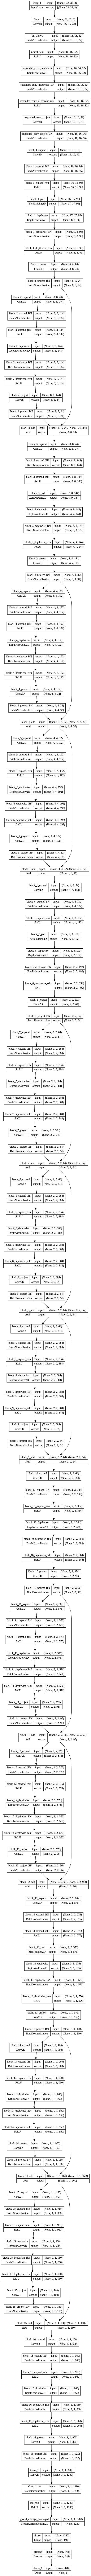

In [ ]:
plot_model(best_mobilenet_model, to_file='classification_model_mobilenet.png', show_shapes=True, show_layer_names=True)

In [ ]:
classification_model_mobilenet_history = classification_model_mobilenet.fit(X_train, y_train, epochs=7, validation_data=(X_val, y_val))

Epoch 1/7
3365/3365 [==============================] - 14s 4ms/step - loss: 0.0291 - f1_score: 0.9759 - val_loss: 0.0451 - val_f1_score: 0.9770
Epoch 2/7
3365/3365 [==============================] - 13s 4ms/step - loss: 0.0265 - f1_score: 0.9785 - val_loss: 0.0459 - val_f1_score: 0.9725
Epoch 3/7
3365/3365 [==============================] - 13s 4ms/step - loss: 0.0220 - f1_score: 0.9831 - val_loss: 0.0536 - val_f1_score: 0.9723
Epoch 4/7
3365/3365 [==============================] - 13s 4ms/step - loss: 0.0206 - f1_score: 0.9839 - val_loss: 0.0607 - val_f1_score: 0.9639
Epoch 5/7
3365/3365 [==============================] - 13s 4ms/step - loss: 0.0188 - f1_score: 0.9851 - val_loss: 0.0537 - val_f1_score: 0.9702
Epoch 6/7
3365/3365 [==============================] - 13s 4ms/step - loss: 0.0173 - f1_score: 0.9867 - val_loss: 0.0578 - val_f1_score: 0.9693
Epoch 7/7
3365/3365 [==============================] - 14s 4ms/step - loss: 0.0157 - f1_score: 0.9884 - val_loss: 0.0588 - val_f1_score:

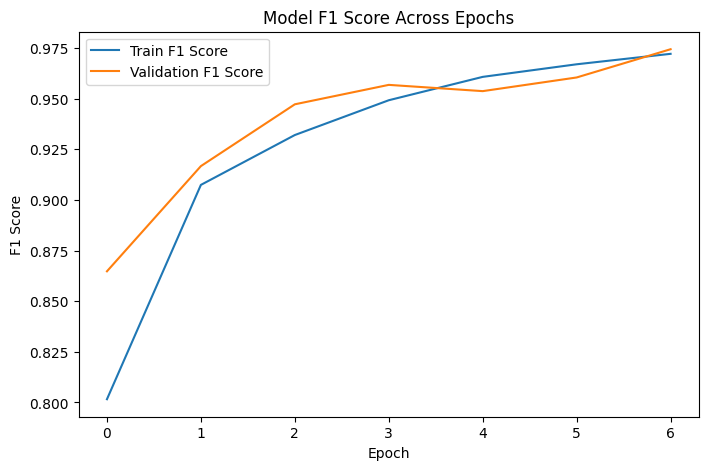

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(classification_model_mobilenet_history.history['f1_score'], label='Train F1 Score')
plt.plot(classification_model_mobilenet_history.history['val_f1_score'], label='Validation F1 Score')
plt.title('Model F1 Score Across Epochs')
plt.ylabel('F1 Score')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
classification_model_mobilenet.evaluate(X_test, y_test)

300/300 [==============================] - 1s 2ms/step - loss: 0.0711 - f1_score: 0.9699


[0.07109705358743668, 0.9699482321739197]

In [ ]:
y_pred_probs_mobilenet = classification_model_mobilenet.predict(X_test)

# Convert probabilities to binary predictions assuming threshold at 0.5
y_pred_mobilenet = (y_pred_probs_mobilenet > 0.5).astype('int').flatten()

300/300 [==============================] - 1s 2ms/step


In [ ]:
conf_matrix_mobilenet = confusion_matrix(y_test, y_pred_mobilenet)

In [ ]:
classification_model.evaluate(X_test, y_test)

300/300 [==============================] - 1s 2ms/step - loss: 0.0483 - f1_score: 0.9662


[0.04827382415533066, 0.9661732912063599]

In [ ]:
classification_model_mobilenet.evaluate(X_test, y_test)

300/300 [==============================] - 1s 2ms/step - loss: 0.0527 - f1_score: 0.9669


[0.052661310881376266, 0.9669225215911865]

In [ ]:
conf_matrix_mobilenet

array([[7151,   49],
       [  87, 2313]])

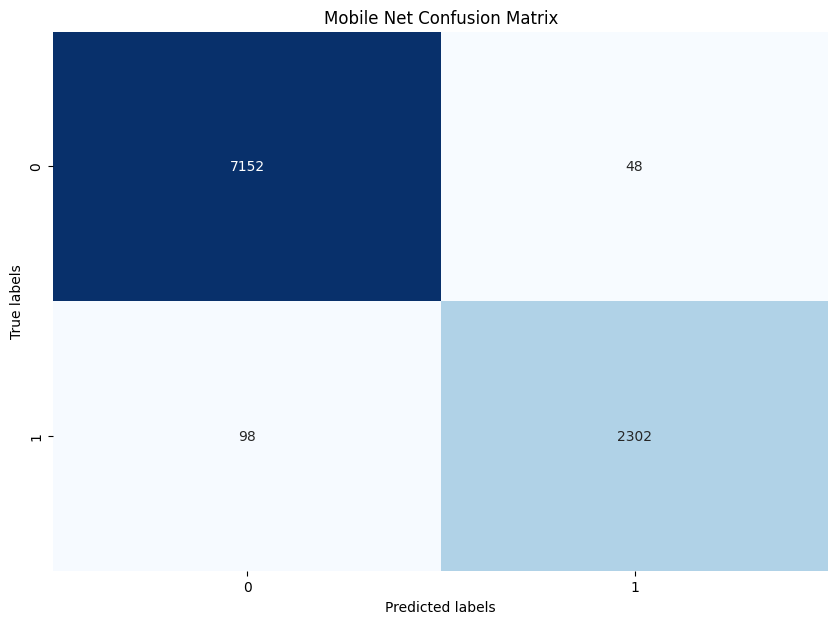

In [ ]:
plt.figure(figsize=(10, 7))  # Set the figure size (optional)
sns.heatmap(conf_matrix_mobilenet, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Mobile Net Confusion Matrix')
plt.show()

In [ ]:
y_pred_probs = classification_model.predict(X_test)

# Convert probabilities to binary predictions assuming threshold at 0.5
y_pred = (y_pred_probs > 0.5).astype('int').flatten()

300/300 [==============================] - 1s 2ms/step


In [ ]:
conf_matrix_ = confusion_matrix(y_test, y_pred)

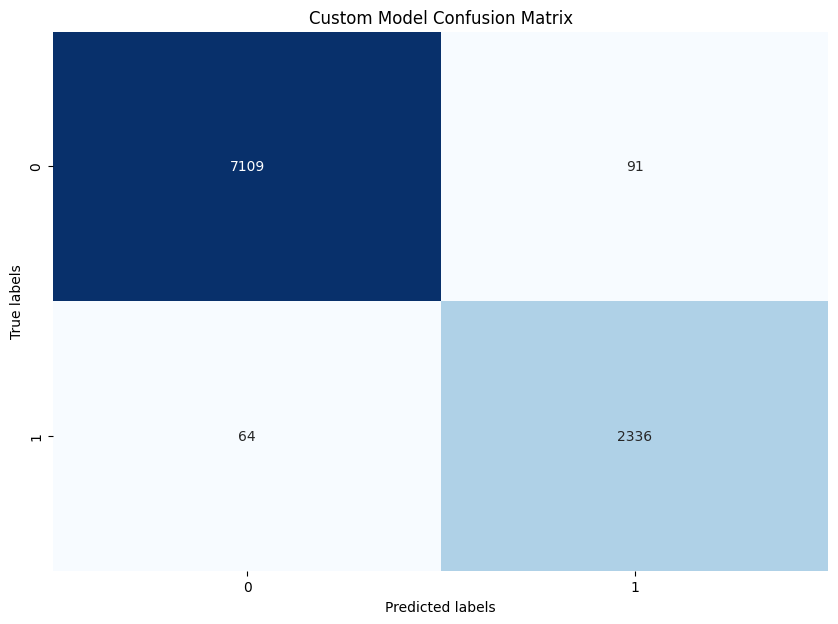

In [ ]:
plt.figure(figsize=(10, 7))  # Set the figure size (optional)
sns.heatmap(conf_matrix_, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Custom Model Confusion Matrix')
plt.show()

In [ ]:
conf_matrix_

array([[7109,   91],
       [  64, 2336]])

In [ ]:
base_model.summary()


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 16, 16, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 16, 16, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 16, 16, 32)           0         ['bn_Conv1[